In [116]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
def load_df(csv_path='train.csv', nrows=None) -> pd.DataFrame:
    """
        JSON 형태로 되어있는 컬럼들을 모아서 DataFrame형태로 바꾸는 함수
        converters : JSON 컬럼들의 값들을 json_loads로 데이터 프레임화 시키는 함수를 적용하는 파라미터
        dtype : 데이터를 불러올 때 fullVisitorId의  dtype을 미리 str로 정의
        nrows :  limit와 같은 존재 너무 크면 오래걸리니까 2만으로 줄임.
    """
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, 
                     nrows=nrows)
    '''
    normalize는 json을 정규화(평평하게)만드는 것이며 이는 중첩된 구조를 하나의 테이블로 펼쳐서, 각각의 요소를 행으로 나타내는 것
    흔히 우리가 아는 테이블의 형태로 나타나게 된다. 
    새로운 컬럼을 for문을 통해서 각 column마다 서브 column name으로 할당
    정규화 되기 전 컬럼은 삭제하고, 새로운 컬럼으로 덮어씌운다.
    '''
    for column in JSON_COLUMNS:
        column_as_df = pd.json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

df = load_df(nrows=450000)

## DROP

In [117]:
drop_columns = ['socialEngagementType','totals_bounces', 'device_browser', 'device_browserVersion', 'device_browserSize', 'device_operatingSystem', 'device_operatingSystemVersion', 'device_mobileDeviceBranding', 'device_mobileDeviceModel', 'device_mobileInputSelector', 'device_mobileDeviceInfo', 'device_mobileDeviceMarketingName', 'device_flashVersion', 'device_language', 'device_screenColors', 'device_screenResolution', 'geoNetwork_subContinent', 'geoNetwork_region', 'geoNetwork_metro', 'geoNetwork_city', 'geoNetwork_cityId', 'geoNetwork_networkDomain', 'geoNetwork_latitude', 'geoNetwork_longitude', 'geoNetwork_networkLocation', 'trafficSource_adwordsClickInfo.criteriaParameters', 'trafficSource_referralPath', 'trafficSource_adwordsClickInfo.page', 'trafficSource_adwordsClickInfo.gclId', 'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_adContent']
df =df.drop(drop_columns,axis=1)

## 전처리
### str 변환 함수

In [118]:
def transform_str (df:pd.DataFrame)-> pd.DataFrame:
    """
        str 형태로 변환하는 함수
    """
    transform_str_columns = ['fullVisitorId']
    df[transform_str_columns]=df[transform_str_columns].astype(str)
    return df

transform_str(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450000 entries, 0 to 449999
Data columns (total 24 columns):
 #   Column                                        Non-Null Count   Dtype 
---  ------                                        --------------   ----- 
 0   channelGrouping                               450000 non-null  object
 1   date                                          450000 non-null  int64 
 2   fullVisitorId                                 450000 non-null  object
 3   sessionId                                     450000 non-null  object
 4   visitId                                       450000 non-null  int64 
 5   visitNumber                                   450000 non-null  int64 
 6   visitStartTime                                450000 non-null  int64 
 7   device_isMobile                               450000 non-null  bool  
 8   device_deviceCategory                         450000 non-null  object
 9   geoNetwork_continent                          450000 non-nu

### str->int 변환 함수
-  totals_visits은 1로만 차있는 데이터라서 변환이 필요 없음.

In [119]:
def change_numeric(df:pd.DataFrame)-> pd.DataFrame :
    '''
        결측치를 처리하고 문자열-> int형으로 형변환하는 함수
    '''
    transform_int_columns = ['totals_hits','totals_pageviews','totals_newVisits','totals_transactionRevenue']
    df[transform_int_columns]=df[transform_int_columns].fillna(0)
    df[transform_int_columns]= np.int64(df[transform_int_columns])
    return df 
    
df=change_numeric(df)
df.describe()


,date,visitId,visitNumber,visitStartTime,totals_hits,totals_pageviews,totals_newVisits,totals_transactionRevenue
count,4.500000e+05,4.500000e+05,450000.000000,4.500000e+05,450000.000000,450000.000000,450000.000000,4.500000e+05
mean,2.016537e+07,1.484198e+09,2.251244,1.484198e+09,4.518738,3.790833,0.779998,1.666658e+06
std,4.674737e+03,8.603210e+06,9.191467,8.603211e+06,9.400551,6.878649,0.414248,5.850758e+07
min,2.016080e+07,1.470207e+09,1.000000,1.470208e+09,1.000000,0.000000,0.000000,0.000000e+00
25%,2.016103e+07,1.477738e+09,1.000000,1.477738e+09,1.000000,1.000000,1.000000,0.000000e+00
50%,2.016121e+07,1.481640e+09,1.000000,1.481640e+09,2.000000,1.000000,1.000000,0.000000e+00
75%,2.017041e+07,1.491517e+09,1.000000,1.491517e+09,4.000000,4.000000,1.000000,0.000000e+00
max,2.017080e+07,1.501657e+09,395.000000,1.501657e+09,500.000000,469.000000,1.000000,2.312950e+10


### 날짜형 데이터로 변환

In [120]:
df['date'] =pd.to_datetime(df['date'], format='%Y%m%d')
df['visitStartTime']=pd.to_datetime(df['visitStartTime'],unit='s')

df['date_of_weekday']=df.visitStartTime.dt.dayofweek
df['date_of_weekday']= df.groupby(df['date_of_weekday'])['fullVisitorId'].nunique()
df['date_of_weekday']=df['date_of_weekday'].dropna()

df['hour_of_day'] = df['visitStartTime'].dt.hour
df['date_of_Month'] = df['visitStartTime'].dt.month

### Revenue

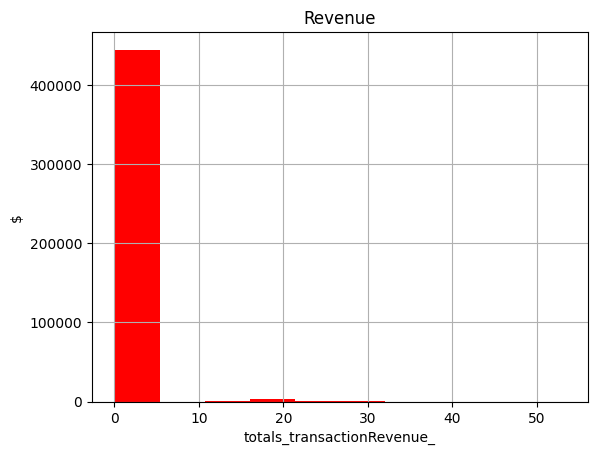

In [121]:
totals_transactionRevenue_median = df[df['totals_transactionRevenue'] != 0]['totals_transactionRevenue'].median()

df['totals_transactionRevenue'] = df['totals_transactionRevenue'].fillna(totals_transactionRevenue_median)

df['totals_transactionRevenue']=np.power(df['totals_transactionRevenue'],1/6).round(2)

df['totals_transactionRevenue'].hist(color='red')
plt.xlabel('totals_transactionRevenue_')
plt.ylabel('$')
plt.title('Revenue')
plt.show()

### ChannelGrouping

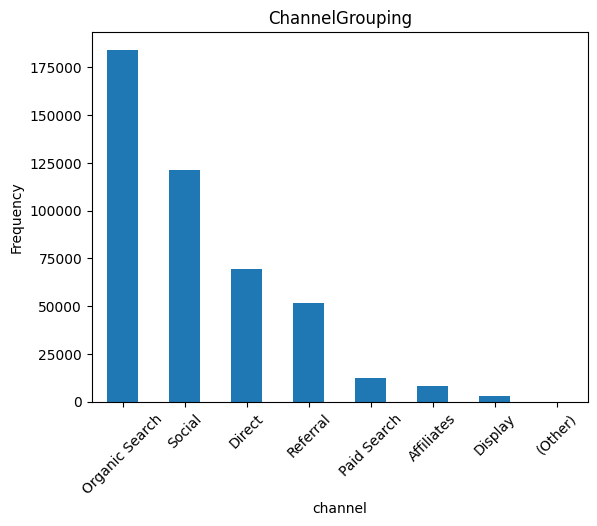

In [122]:
df.channelGrouping.value_counts().plot.bar()
plt.xlabel('channel')
plt.ylabel('Frequency')
plt.title('ChannelGrouping')
plt.xticks(rotation=45)
plt.show()

### GeoNetwork_continent

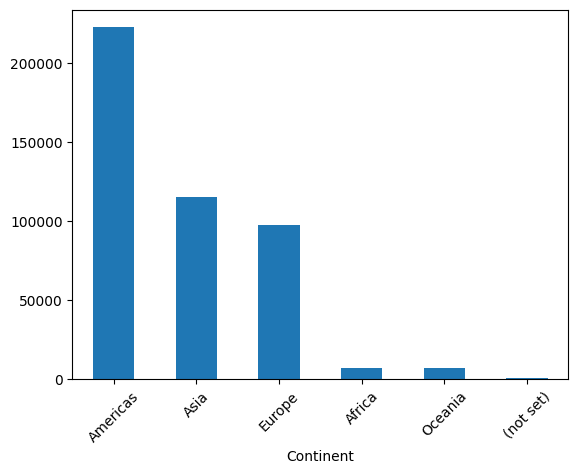

In [123]:
df.geoNetwork_continent.value_counts().plot.bar()
plt.xlabel('Continent')
plt.xticks(rotation=45)
plt.show()

### 첫 방문자와 재 방문자의 비율

In [124]:
first_session = df[df.visitNumber == 1]['visitNumber'].count()
returning_session_ratio  = df[df.visitNumber != 1]['visitNumber'].count()

session_count= df.visitNumber.count()

first_session_ratio = (first_session/session_count * 100)
print(f"첫 방문자의 비율: {first_session_ratio:.2f}%")

returning_session_ratio  = (returning_session_ratio /session_count * 100)
print(f"재방문자의 비율: {returning_session_ratio :.2f}%")

첫 방문자의 비율: 78.00%
재방문자의 비율: 22.00%


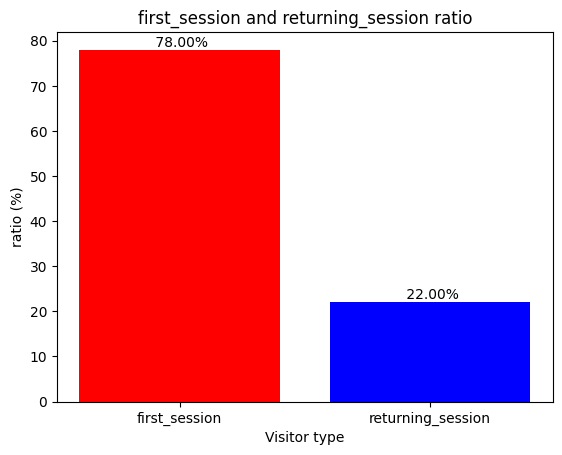

In [125]:
labels = ['first_session', 'returning_session']
ratios = [first_session_ratio, returning_session_ratio]

plt.bar(labels, ratios, color=['red', 'blue'])


plt.title('first_session and returning_session ratio')
plt.xlabel('Visitor type')
plt.ylabel('ratio (%)')
plt.text(0, ratios[0]+0.7, f'{ratios[0]: .2f}%', ha='center')
plt.text(1, ratios[1]+0.7, f'{ratios[1]: .2f}%', ha='center')

# 그래프 출력
plt.show()

## 채널별 효과 분석 (재혁)
    - 캠페인으로 들어온 사람은 다른 사람과 다른 특징을 가지고 있는지 분석
    - 매출이 우수한 채널이 있는지

### 시간대 별 추이

캠페인에 참여한 사람들은 11시에 접속수가 가장 적고, 3,15,18,20시가 가장 많은 접속이 이루어지는걸 볼 수 있음.

캠페인 참여 안한 사람들은 5시에 최저, 17,18시가 가장 많은 접속 했음을 알 수 있고,  캠페인에 참여하지 않은 사람들은 주로 오후에 활동하는것으로 판단된다.

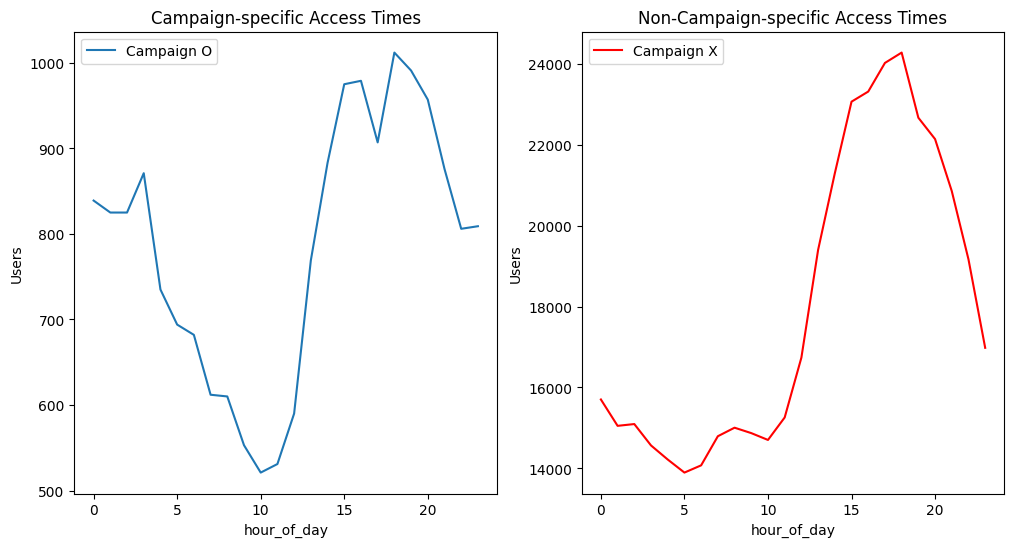

In [126]:
#캠페인에 따른 시간대 별 차이
df_set=df.loc[df['trafficSource_campaign'] != '(not set)']
df_not_set=df.loc[df['trafficSource_campaign'] == '(not set)']

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
df_set.groupby('hour_of_day')['hour_of_day'].value_counts().plot(kind='line',label='Campaign O')
plt.title('Campaign-specific Access Times')
plt.ylabel('Users')
plt.legend()

plt.subplot(1,2,2)
df_not_set.groupby('hour_of_day')['hour_of_day'].value_counts().plot(kind='line',color='red',label='Campaign X')
plt.title('Non-Campaign-specific Access Times')
plt.ylabel('Users')
plt.legend()

### 요일별 차이 
- 캠페인에 참여한 사람들의 데이터는 안나오는 문제가 발생 = 모두다 NaN값

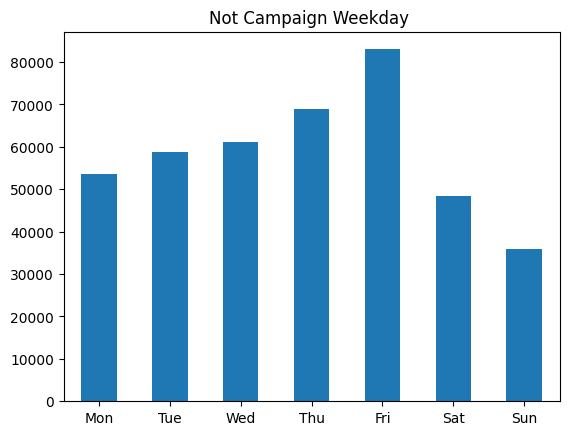

In [127]:
# 캠페인 별 요일별 차이

df_not_set['date_of_weekday'].dropna().plot(kind='bar')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation = 0)
plt.title('Not Campaign Weekday ')
plt.show()


### 월별 추이 

캠페인에 참여한 그룹은 6월과 11월에 가장 많은 접속을, 7월달에 저조한 접속을 기록 \
반면에 캠페인을 통해 들어오지 않은 그룹은 11월에 가장 많은 접속을, 7월에 저조한 기록을 보여줌

 - 차이점 : 6월에 캠페인을 참여하지 않은 그룹은 왜 상대적으로 접속을 안했을까? 
 - 7월에는 왜 저조한가?  
 - 매출을 본다면 11월에 가장 많은 매출이 나올것이다.!

Text(0.5, 0, 'Month')

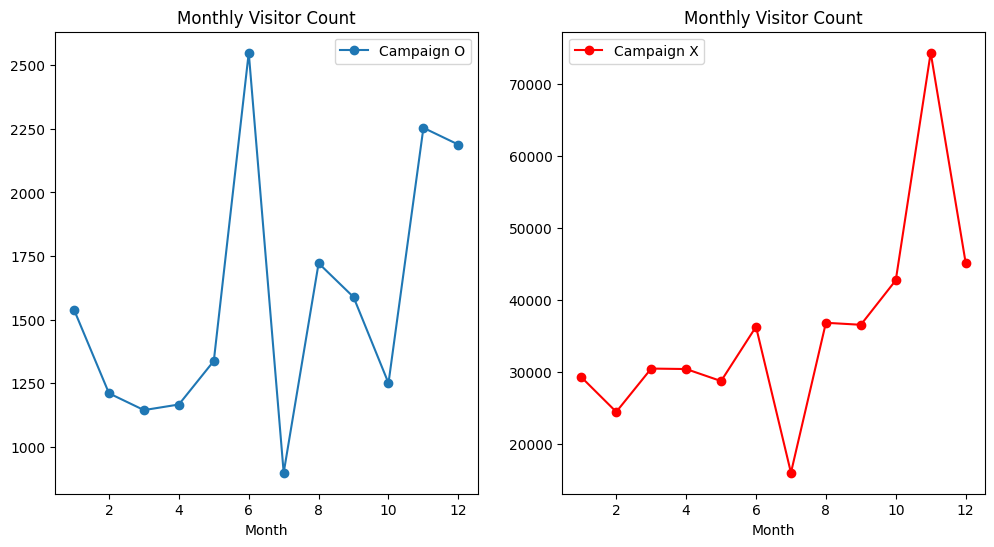

In [174]:
# 캠페인 별 접속한 월 추이
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
df_set['date_of_Month'].value_counts().sort_index().plot(kind='line',label='Campaign O', marker='o')
plt.title('Monthly Visitor Count')
plt.xlabel('Month')
plt.legend()

plt.subplot(1,2,2)
df_not_set['date_of_Month'].value_counts().sort_index().plot(kind='line',color='red',label='Campaign X', marker='o')
plt.title('Monthly Visitor Count')
plt.xlabel('Month')
plt.legend()


### 캠페인 여부에 따른 검색 유형

- 캠패인에 참여 안한 사람들은 40%는 Organic( 검색엔진에 키워드를 통해 웹사이트에 유입)

  - 27%의 사람들은 Social을 통한 유입, 14%는 Direct로 유입,  0.3%의 사람들이 Paid Search(유료 광고 )로 유입

-  캠페인에 참여한 사람들은 55% 사람들은Paid Search(유료 검색)으로 들어옴.
 
   - 44%의 사람들이 Affiliates(제휴 | 계열사) 로 들어옴.

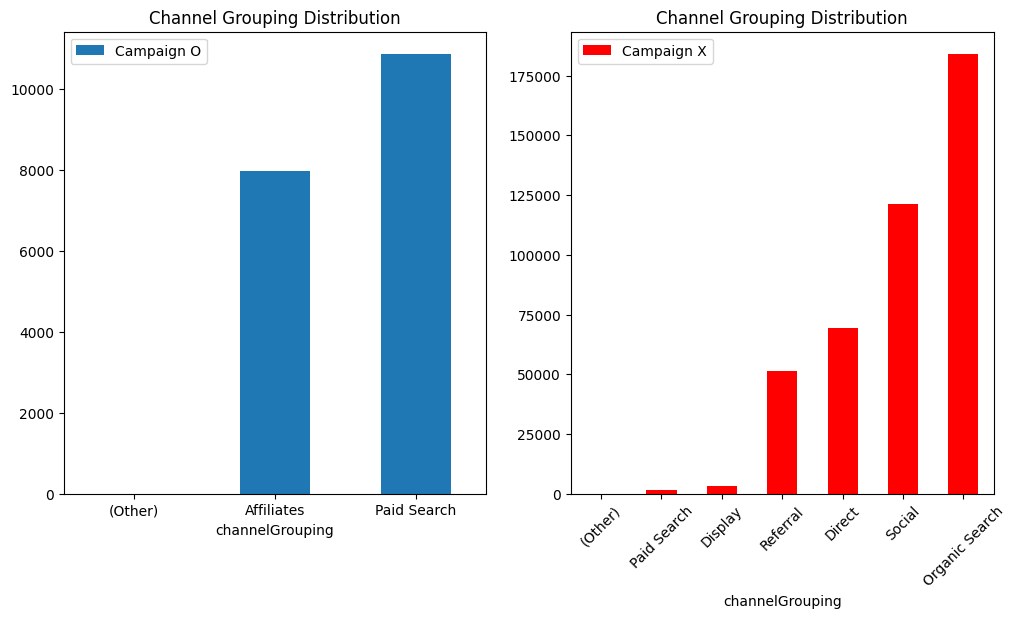

In [175]:
# 켐페인 별 검색 유형  
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
df_set['channelGrouping'].value_counts().sort_values().plot(kind='bar',label='Campaign O')
plt.title('Channel Grouping Distribution')
plt.xticks(rotation = 0)
plt.legend()


plt.subplot(1,2,2)
df_not_set['channelGrouping'].value_counts().sort_values().plot(kind='bar',color='red', label='Campaign X')
plt.title('Channel Grouping Distribution')
plt.xticks(rotation=45)
plt.legend()

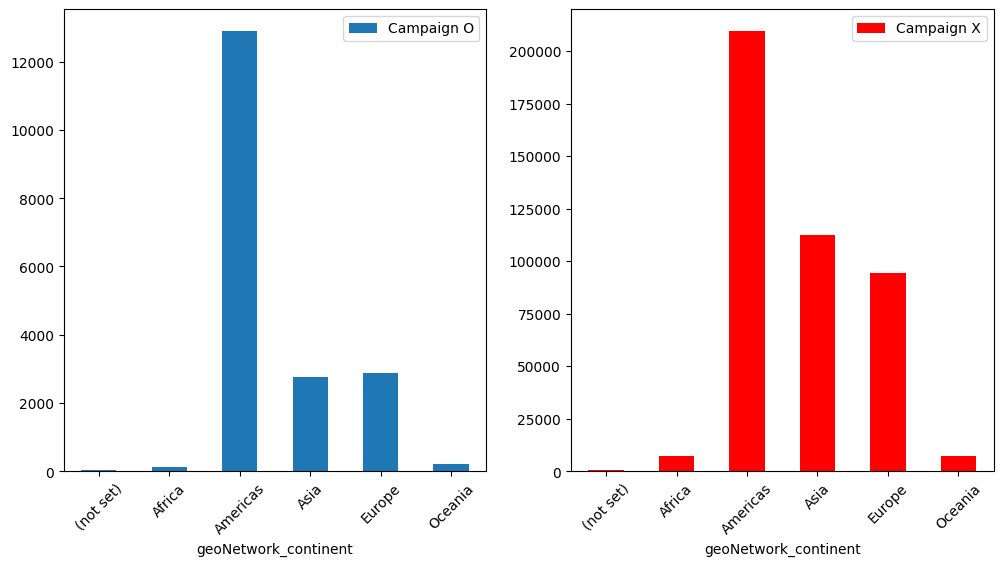

In [144]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
df_set['geoNetwork_continent'].value_counts().sort_index().plot(kind='bar',label='Campaign O')
plt.xticks(rotation=45)
plt.legend()

plt.subplot(1,2,2)
df_not_set['geoNetwork_continent'].value_counts().sort_index().plot(kind='bar',color='red',label='Campaign X')
plt.xticks(rotation=45)
plt.legend()

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450000 entries, 0 to 449999
Data columns (total 27 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   channelGrouping                               450000 non-null  object        
 1   date                                          450000 non-null  datetime64[ns]
 2   fullVisitorId                                 450000 non-null  object        
 3   sessionId                                     450000 non-null  object        
 4   visitId                                       450000 non-null  int64         
 5   visitNumber                                   450000 non-null  int64         
 6   visitStartTime                                450000 non-null  datetime64[ns]
 7   device_isMobile                               450000 non-null  bool          
 8   device_deviceCategory                         450000 n

### 캠페인 별 유입 소스 차이
2개의 그래프 모두 다 Google이 1등을 차지 했지만
캠페인에 참여한 사람들은 Partners를 통해 많이 들어온다.  ->> 검색 유형에서도 알 수 있듯이 Affiliates와 연관이 있을 것이라고 생각

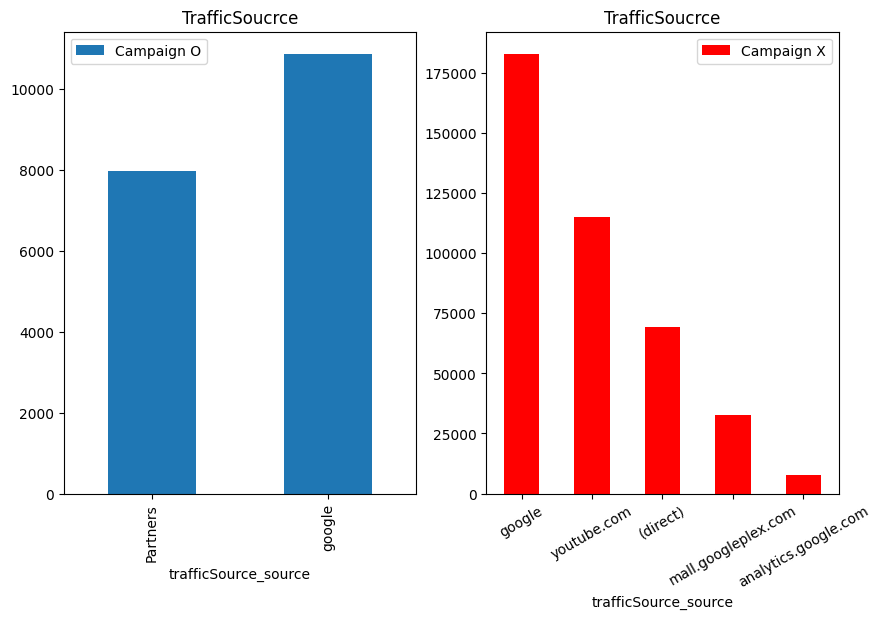

In [178]:
#캠페인 별 유입 소스 차이
top5_source=df_not_set['trafficSource_source'].value_counts().nlargest(n=5)
plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
df_set['trafficSource_source'].value_counts().sort_index().plot(kind='bar',label='Campaign O')
plt.title('TrafficSoucrce')
plt.legend()

plt.subplot(1,2,2)
top5_source.plot(kind='bar',label='Campaign X',color='red')
plt.title('TrafficSoucrce')
plt.xticks(rotation =30)
plt.legend()

### 캠페인 별 매출 추이 
   - 12월달에 매출이 가장 많은 것을 알 수 있음,  11월도 매출이 높은 편이긴 하나  접속자 수에 비하면 살짝 아쉬움
   - 접속자가 적은 7월은 매출 꼴등을 기록함
   - 6월에도 접속자 수에 비해서는 매출이 안나옴

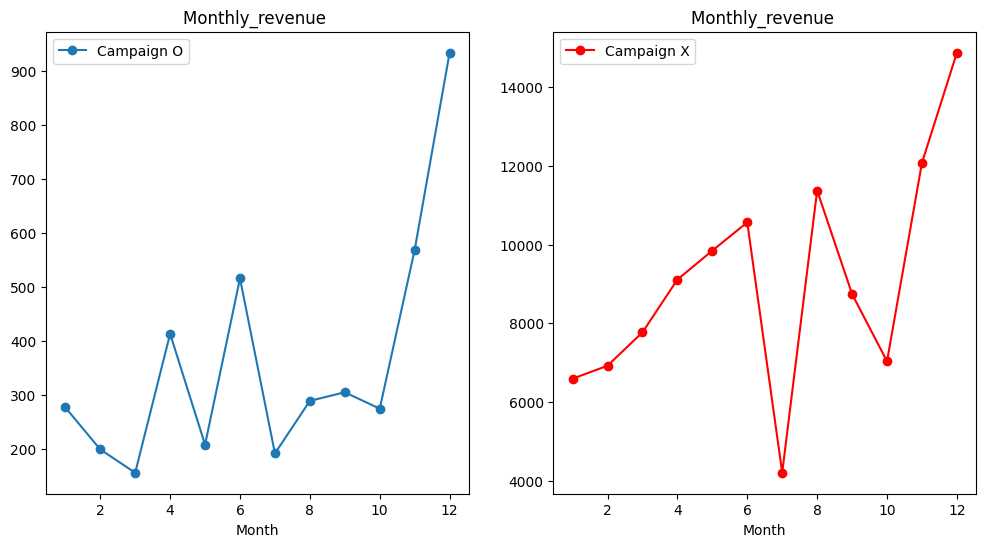

In [180]:
#캠페인 별 매출 추이
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
df_set.groupby('date_of_Month')['totals_transactionRevenue'].sum().plot(kind='line',label='Campaign O' ,marker='o')
plt.title('Monthly_revenue ')
plt.xlabel('Month')
plt.legend()


plt.subplot(1,2,2)
df_not_set.groupby('date_of_Month')['totals_transactionRevenue'].sum().plot(kind='line',label='Campaign X',color='red', marker='o')
plt.title('Monthly_revenue ')
plt.xlabel('Month')
plt.legend()